In [1]:
import subprocess
import shutil
import os

In [2]:
# Blosm Data Path
blosm_overlay_file_path = r"C:\Users\anubh\Downloads\Blosm - Premium\data\texture\overlay.png"
blender_path = r"C:\Program Files\Blender Foundation\Blender 4.2\blender.exe"
automation_script = "./blosm.py"

# Coordinates of the area to be rendered
min_lat = "34.07201"
max_lat = "34.21606"
min_long = "77.45396"
max_long = "77.62802"

# Create a folder to store the generated images
output_folder = rf"./generated_images/{min_lat}_{max_lat}_{min_long}_{max_long}"

In [3]:
process = subprocess.Popen(
    [
        blender_path, '--python', 
        automation_script, 
        '--', 
        min_lat, 
        max_lat, 
        min_long, 
        max_long
    ], 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE, 
    text=True
)

overlay_file = None

# Print the output in real-time
while True:
    output = process.stdout.readline()
    if output == '' and process.poll() is not None:
        break
    if output:
        print(output.strip())
        if (output.strip() == "Info: Overlay import is finished!"):
            # If overlay_file_path not exist then create the folder
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            # Copy the stored overlay image to the output folder
            overlay_file_path = output_folder + "/overlay.png"
            overlay_file = shutil.copyfile(blosm_overlay_file_path, overlay_file_path)
            
            # Terminate the process
            process.terminate()
            break

Obtaining dependency information for pyproj from https://files.pythonhosted.org/packages/26/0c/b084e8839a117eaad8cb4fbaa81bbb24c6f183de0ee95c6c4e2770ab6f09/pyproj-3.7.0-cp311-cp311-win_amd64.whl.metadata
Using cached pyproj-3.7.0-cp311-cp311-win_amd64.whl.metadata (31 kB)
Obtaining dependency information for certifi from https://files.pythonhosted.org/packages/a5/32/8f6669fc4798494966bf446c8c4a162e0b5d893dff088afddf76414f70e1/certifi-2024.12.14-py3-none-any.whl.metadata
Using cached certifi-2024.12.14-py3-none-any.whl.metadata (2.3 kB)
Using cached pyproj-3.7.0-cp311-cp311-win_amd64.whl (6.2 MB)
Using cached certifi-2024.12.14-py3-none-any.whl (164 kB)
Info: Overlay import is finished!


Processing: tree_cover with color [0, 100, 0]


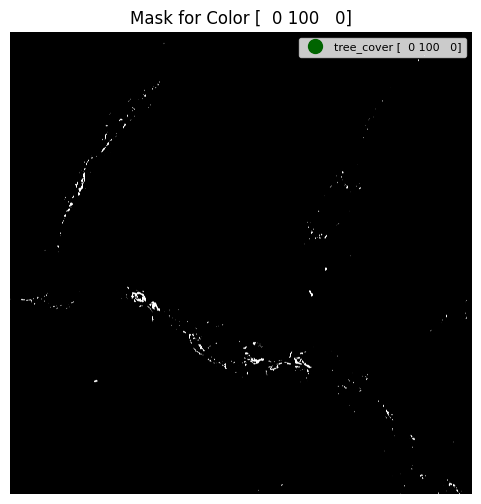

Processing: shrub_land with color [255, 187, 34]


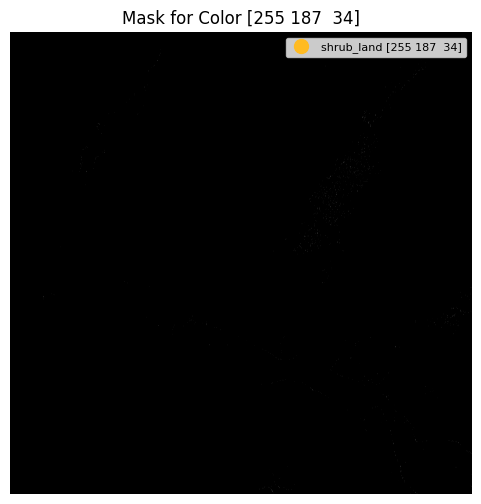

Processing: grass_land with color [255, 255, 76]


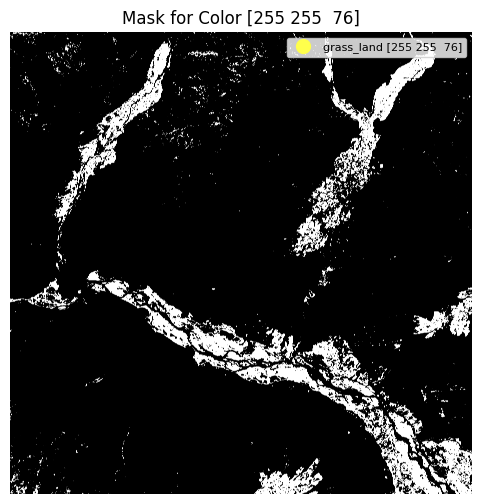

Processing: crop_land with color [240, 150, 255]


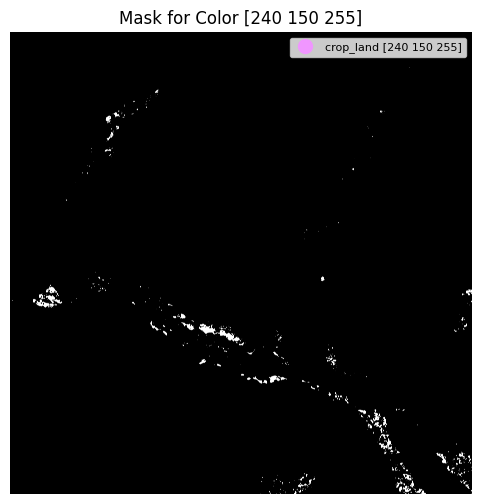

Processing: built_up with color [250, 0, 0]


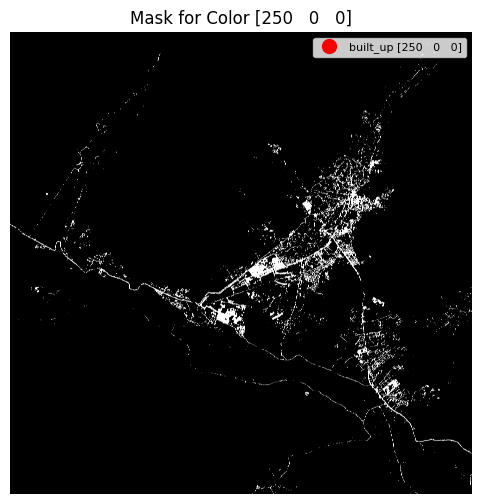

Processing: bare_sparse with color [180, 180, 180]


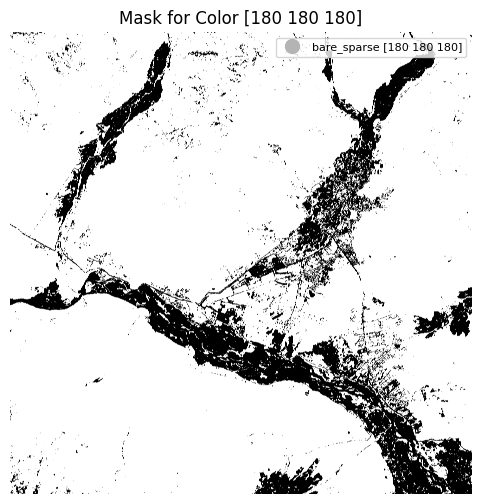

Processing: snow_ice with color [240, 240, 240]


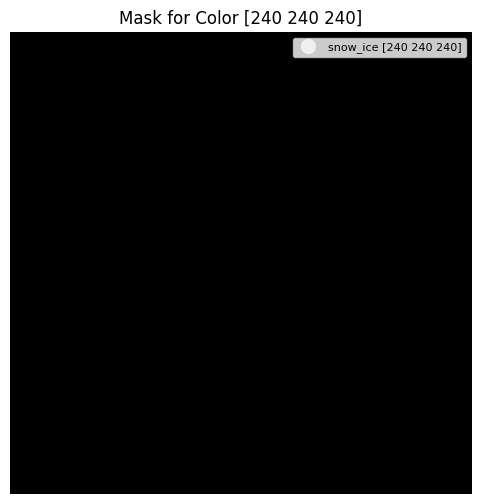

Processing: water_bodies with color [0, 100, 200]


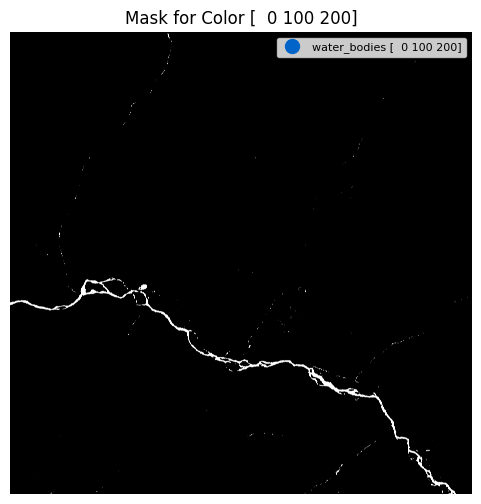

Processing: herbaceous_wetland with color [0, 150, 160]


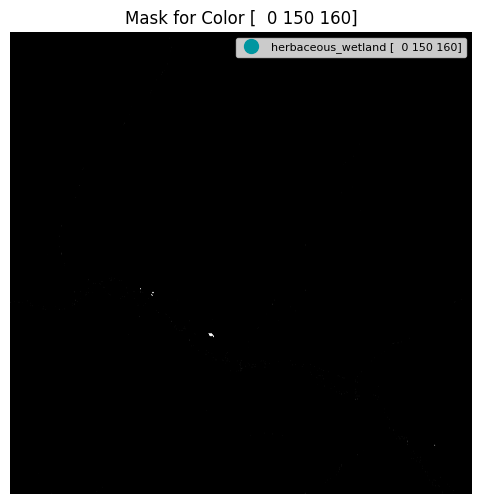

Processing: mangroves with color [0, 207, 117]


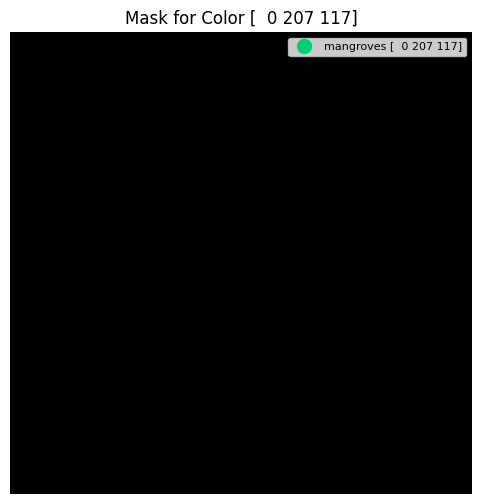

Processing: moss_lichen with color [250, 230, 160]


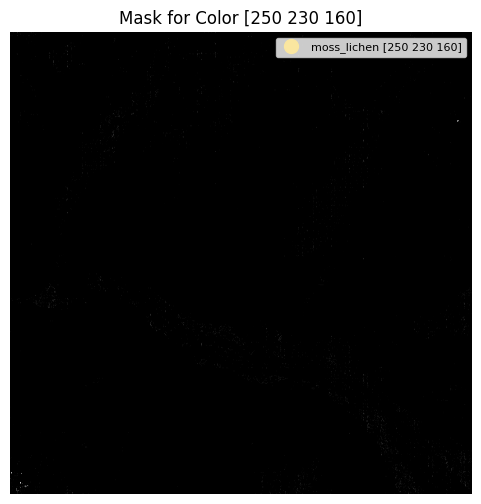

In [13]:
from PIL import Image, ImageEnhance, ImageFilter, ImageChops
import numpy as np
import matplotlib.pyplot as plt

# Color Coding of the ESA World Cover [https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf]
color_coding = {
    "tree_cover": [0, 100, 0],
    "shrub_land": [255, 187, 34],
    "grass_land": [255, 255, 76],
    "crop_land": [240, 150, 255],
    "built_up": [250, 0, 0],
    "bare_sparse": [180, 180, 180],
    "snow_ice": [240, 240, 240],
    "water_bodies": [0, 100, 200],
    "herbaceous_wetland": [0, 150, 160],
    "mangroves": [0, 207, 117],
    "moss_lichen": [250, 230, 160],
}
RGB_TOLERANCE = 40  # Allow a tolerance range of +/- 40 for each RGB channel

Image.MAX_IMAGE_PIXELS = 10000000000

def within_tolerance(pixel, target_rgb, tolerance):
    """Check if a pixel is within the tolerance range of the target RGB color."""
    return all(abs(int(pixel[i]) - int(target_rgb[i])) <= tolerance for i in range(3))

# Sharpen the image and enhance the colors
def sharpen_and_refine_colors(input_image_path, output_image_path, sharpen_factor=2.0, color_factor=1.5, contrast_factor=1.2):
    # Open the image
    img = Image.open(input_image_path)
    
    # Sharpen the image
    sharpened_img = img.filter(ImageFilter.SHARPEN)
    
    # Further sharpen using an additional sharpen factor (if desired)
    enhancer = ImageEnhance.Sharpness(sharpened_img)
    sharpened_img = enhancer.enhance(sharpen_factor)
    
    # Enhance the color (increase saturation)
    enhancer = ImageEnhance.Color(sharpened_img)
    sharpened_img = enhancer.enhance(color_factor)
    
    # Adjust contrast (make colors more distinct)
    enhancer = ImageEnhance.Contrast(sharpened_img)
    sharpened_img = enhancer.enhance(contrast_factor)
    
    # Save the enhanced image
    sharpened_img.save(output_image_path)
    
    print(f"Sharpened and refined image saved to {output_image_path}")
    
    # Return the sharpened image
    return sharpened_img, output_image_path

# Multiply the image with itself to increase the contrast and saturation and save the image
def multiply_image_by_self(input_image_path, output_image_path, contrast_factor=1.2):
    # Open the image
    img = Image.open(input_image_path)

    multiply_image = ImageChops.multiply(img, img)
    
    # Adjust contrast (make colors more distinct)
    enhancer = ImageEnhance.Contrast(multiply_image)
    multiply_image = enhancer.enhance(contrast_factor)
    
    # Save the enhanced image
    multiply_image.save(output_image_path)
    
    print(f"Sharpened and refined image saved to {output_image_path}")
    
    return multiply_image, output_image_path
    

# Create a mask for the given color
def create_mask(input_image_path, output_mask_path, target_rgb, tolerance, land_type):
    # Open the image & convert to RGB
    img = Image.open(input_image_path).convert("RGB")
    
    # Convert image data to numpy array
    img_array = np.array(img)

    # Create a mask using the tolerance-based function
    mask_image = np.zeros(img_array.shape[:2], dtype=np.uint8)  # Black mask
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if within_tolerance(img_array[i, j], target_rgb, tolerance):
                mask_image[i, j] = 255  # Set matching pixels to white

    # Save the mask as a new image
    Image.fromarray(mask_image).save(output_mask_path)
    
    # Display mask for debugging
    plt.figure(figsize=(6, 6))
    plt.title(f"Mask for Color {target_rgb}")
    plt.imshow(mask_image, cmap='gray')
    plt.axis('off')
    
    # Add legend with the color and RGB values
    color_patch = plt.Line2D([0], [0], color=np.array(target_rgb) / 255, marker='o', markersize=10, linestyle='None', label=f"{land_type} {target_rgb}")
    plt.legend(handles=[color_patch], loc='upper right', fontsize=8, frameon=True)
    plt.show()  

    return img, mask_image

# Image to be processed
# overlay_file = r"./generated_images/34.072_34.2161_77.454_77.628/overlay.png"
# output_image_path = r'./generated_images/34.072_34.2161_77.454_77.628/sharpened_overlay.png'
# multiply_image_path = r'./generated_images/34.072_34.2161_77.454_77.628/multiply_overlay.png'
overlay_file = r"./generated_images/33.60925513738903_33.65890841019596_75.79202885747709_75.90898450959517/overlay.png"
output_image_path = r'./generated_images/33.60925513738903_33.65890841019596_75.79202885747709_75.90898450959517/sharpened_overlay.png'
multiply_image_path = r'./generated_images/33.60925513738903_33.65890841019596_75.79202885747709_75.90898450959517/multiply_overlay.png'


# Load the overlay image and extract the area of the given color
if overlay_file:
    # # Apply sharpening and color refinement
    # sharpen_image, sharpen_image_path = sharpen_and_refine_colors(overlay_file, output_image_path, sharpen_factor=2.0, color_factor=1.5, contrast_factor=1.2)
    
    for land_type, rgb in color_coding.items():
        print(f"Processing: {land_type} with color {rgb}")
        create_mask(
            overlay_file, 
            output_folder + f"/{land_type}.png", 
            np.uint8(rgb), 
            RGB_TOLERANCE,
            land_type,
        )